In [1]:
import pandas as pd
import numpy as np
import sklearn, sklearn.datasets, sklearn.model_selection, sklearn.metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import xgboost as xgb

import matplotlib.pyplot as plt
import matplotlib as mpl
# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from csv import writer
import numpy as np
import seaborn as sns
%matplotlib inline
from xgboost import plot_importance, plot_tree

In [2]:
df = pd.read_csv('../data_etl.csv',parse_dates=['Date'],index_col='Date')
xDay = 1
shiftXday = xDay * -1
df['xDay_future_close'] = df['spx_close'].shift(shiftXday)
df['xDay_close_future_pct'] = df['xDay_future_close'].pct_change(xDay)
df['xDay_close_pct'] = df['spx_close'].pct_change(xDay)
df['s5th_close_pct'] = df['s5th_close'].pct_change(xDay)
df['s5fi_close_pct'] = df['s5fi_close'].pct_change(xDay)
feature_names = ['ema_signal','usdjpy_macdsignal','dxy_macdsignal','duj_macdsignal','xDay_close_pct','s5th_close_pct','s5fi_close_pct']
df = df.dropna()
features = df[feature_names]
targets = df['xDay_close_future_pct']
X=features
y=targets
X = X.reset_index()
X = X.drop(columns=['Date'])
y =y.reset_index()
y = y.drop(columns=['Date'])
train_size = int(0.778 * features.shape[0])
train_features = features[:train_size]
train_targets = targets[:train_size]
test_features = features[train_size:]
test_targets = targets[train_size:]
X_train, X_test, y_train, y_test = train_features, test_features, train_targets, test_targets


In [3]:
model = xgb.XGBRegressor(random_state=27, colsample_bytree = 0.1,learning_rate =0.01,
                         max_Features=0.9, max_depth=9,n_estimators=1000)
    #n_e:1000
model.fit(X_train,y_train)

train_preds = model.predict(X_train)
preds = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,preds))

train_rmse = np.sqrt(mean_squared_error(train_targets,train_preds))
test_rmse = np.sqrt(mean_squared_error(test_targets,preds))
predictions = np.concatenate((train_preds,preds),axis=None)
predictions = pd.DataFrame(predictions,columns=['predictions'])
return_data = [df['spx_open'],df['spx_close'],df['xDay_close_future_pct']]
return_header = ["open","close","real_pct"]
df_return = pd.concat(return_data,axis=1,keys=return_header)
df_return = df_return.reset_index()
df_return = pd.concat([df_return,predictions],axis=1)

    

[16:28:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { max_Features } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [4]:
    df_return= df_return.assign(isBuy="")
    row = 0

    for x in df_return['predictions']:
        lastRow = row -1
        if x > -1:

            if df_return['predictions'][row]>0:
                df_return['isBuy'][row] = 1
            else:
                df_return['isBuy'][row] = 0
        row = row +1
    df_return = df_return.assign(signal="hold")
    row = 0
    isBought = 0
    for x in df_return['predictions']:
        lastRow = row -1
        if x > -1 and lastRow > -1:
            #print("lastRow:",lastRow,"row:",row)
            if df_return['isBuy'][0]==1:
                df_return['signal'][0] = "buy"
                isBought = 1
            if df_return['isBuy'][row]==1 and df_return['isBuy'][lastRow]==0:
                df_return['signal'][row] = "buy"
                isBought = 1
            if isBought ==1 and df_return['isBuy'][row]==0 and df_return['isBuy'][lastRow]==1:
                df_return['signal'][row] = "sell"
        row = row +1
    df_return= df_return.assign(bsPrice="0")
    row = 0
    for x in df_return['signal']:
        if(row < (df_return.shape[0]-1)):
            tmp = row+1
        if  df_return['signal'][row]== "buy":
          #  df_return['bsPrice'][tmp] = df_return['open'][tmp]
            df_return['bsPrice'][row] = df_return['open'][tmp]

        if df_return['signal'][row] == "sell":
         #   df_return['bsPrice'][tmp] = df_return['open'][tmp]
            df_return['bsPrice'][row] = df_return['open'][tmp]
        row = row +1
    df_return = df_return.assign(point="0")
    row = 0
    bPrice = 0
    sPrice = 0
    for x in df_return['signal']:

        if  df_return['signal'][row]== "buy":
            bPrice = df_return['bsPrice'][row]

        if df_return['signal'][row] == "sell":
            sPrice = df_return['bsPrice'][row]

            df_return['point'][row] = sPrice - bPrice
        row = row +1
    df_return

<ipython-input-4-f48842c7da05>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-4-f48842c7da05>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-4-f48842c7da05>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-4-f48842c7da05>:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/panda

,Date,open,close,real_pct,predictions,isBuy,signal,bsPrice,point
0,2011-06-20,1271.50,1278.36,0.013423,0.004956,1,buy,1278.4,0
1,2011-06-21,1278.40,1295.52,-0.006468,-0.001566,0,sell,1295.48,17.08
2,2011-06-22,1295.48,1287.14,-0.002828,-0.002079,0,hold,0,0
3,2011-06-23,1286.60,1283.50,-0.011726,-0.002949,0,hold,0,0
4,2011-06-24,1283.04,1268.45,0.009184,0.002685,1,buy,1268.44,0
...,...,...,...,...,...,...,...,...,...
2433,2021-02-19,3921.16,3906.72,-0.007733,0.000266,1,buy,3885.55,0
2434,2021-02-22,3885.55,3876.51,0.001256,0.002036,1,hold,0,0
2435,2021-02-23,3885.55,3881.38,0.011352,0.000167,1,hold,0,0
2436,2021-02-24,3873.71,3925.44,-0.024479,-0.001023,0,sell,3915.8,30.25


In [5]:
df_return.to_csv('df_return_xgboost.csv')

In [6]:
def spreadReturn(start_date,end_date,year):
    df_point = df_return.loc[df_return['Date'].between(start_date,end_date,inclusive=False)]
    df_point=df_point.reset_index()
    row = 0
    point = 0

    for x in df_point['point']:
        point =int(df_point['point'][row]) + point
        row = row +1
    List = [year,point,train_rmse,test_rmse]

    with open('xgboost_return.csv','a')as f_object:
    #    with open('result_b.csv','a')as f_object:
        writer_object = writer(f_object)
        writer_object.writerow(List)
        f_object.close()         

In [7]:
List = ['year','point','train_rmse','test_rmse']

with open('xgboost_return.csv','a')as f_object:
    #    with open('result_b.csv','a')as f_object:
    writer_object = writer(f_object)
    writer_object.writerow(List)
    f_object.close() 

In [8]:
spreadReturn("2011-01-01","2011-12-31","2011")
spreadReturn("2012-01-01","2012-12-31","2012")
spreadReturn("2013-01-01","2013-12-31","2013")
spreadReturn("2014-01-01","2014-12-31","2014")
spreadReturn("2015-01-01","2015-12-31","2015")
spreadReturn("2016-01-01","2016-12-31","2016")
spreadReturn("2017-01-01","2017-12-31","2017")
spreadReturn("2018-01-01","2018-12-31","2018")
spreadReturn("2019-01-01","2019-12-31","2019")
spreadReturn("2020-01-01","2020-12-31","2020")
spreadReturn("2021-01-01","2021-02-26","2021") 

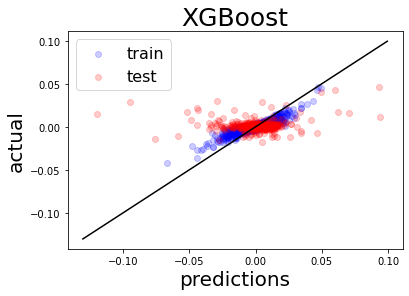

In [9]:
plt.scatter(train_targets,train_preds, alpha=0.2, color='b',label='train')
plt.scatter(test_targets,preds, alpha=0.2, color='r',label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')
plt.rcParams['font.size']='16'
# Set the axis labels and show the plot
plt.xlabel('predictions',fontsize = 20)
plt.ylabel('actual',fontsize = 20)
plt.title('XGBoost',fontsize = 25)
plt.legend()
plt.savefig('XGBoost_scatter_compare.png',dpi=300)
plt.show()

In [10]:
df_spx = pd.read_csv('../s&p_return.csv')

In [11]:
df = pd.read_csv('xgboost_return.csv')
df = df.dropna()
df

,year,point,train_rmse,test_rmse
0,2011,1084,0.005502,0.016332
1,2012,896,0.005502,0.016332
2,2013,989,0.005502,0.016332
3,2014,1029,0.005502,0.016332
4,2015,1430,0.005502,0.016332
5,2016,1212,0.005502,0.016332
6,2017,640,0.005502,0.016332
7,2018,1600,0.005502,0.016332
8,2019,208,0.005502,0.016332
9,2020,552,0.005502,0.016332


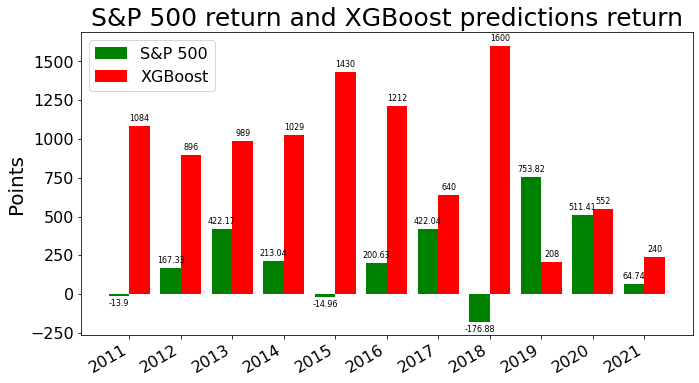

In [12]:
labels = ['2011','2012','2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020','2021']
x = np.arange(len(df['year']))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width/2,df_spx['point'], width, label='S&P 500',color ='g')
rects2 = ax.bar(x + width/2,df['point'] , width, label='XGBoost', color = 'r')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Points',fontsize = 20)
ax.set_title('S&P 500 return and XGBoost predictions return',fontsize = 25)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3, fontsize=8 )
ax.bar_label(rects2, padding=3, fontsize=8 )

fig.tight_layout()
plt.rcParams['font.size']='16'
plt.legend(loc =2,prop={'size':16})
fig.autofmt_xdate()
plt.savefig('XGBoost_return.png',dpi=300)
plt.show()

In [13]:
#df_return.to_csv('df_return_xgboost.csv')

In [14]:
df_vs_features =['Date','close','predictions']
df_vs = df_return[df_vs_features]
df_vs.head(5)

,Date,close,predictions
0,2011-06-20,1278.36,0.004956
1,2011-06-21,1295.52,-0.001566
2,2011-06-22,1287.14,-0.002079
3,2011-06-23,1283.50,-0.002949
4,2011-06-24,1268.45,0.002685


In [15]:
df_vs['pClose'] = df_vs['close']*(1+df_vs['predictions'])

<ipython-input-15-e78ad7227175>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [16]:
df_vs['pClose'] = df_vs['pClose'].shift(1)
df_vs.head(5)

<ipython-input-16-90c0fa3be022>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Date,close,predictions,pClose
0,2011-06-20,1278.36,0.004956,NaN
1,2011-06-21,1295.52,-0.001566,1284.695104
2,2011-06-22,1287.14,-0.002079,1293.491688
3,2011-06-23,1283.50,-0.002949,1284.464176
4,2011-06-24,1268.45,0.002685,1279.714883


In [17]:
df_vs = df_vs.dropna()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

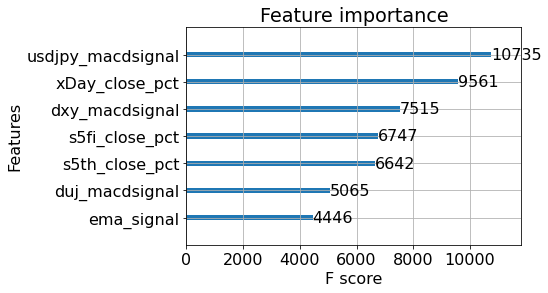

In [18]:
plot_importance(model)

In [19]:
df_return

,Date,open,close,real_pct,predictions,isBuy,signal,bsPrice,point
0,2011-06-20,1271.50,1278.36,0.013423,0.004956,1,buy,1278.4,0
1,2011-06-21,1278.40,1295.52,-0.006468,-0.001566,0,sell,1295.48,17.08
2,2011-06-22,1295.48,1287.14,-0.002828,-0.002079,0,hold,0,0
3,2011-06-23,1286.60,1283.50,-0.011726,-0.002949,0,hold,0,0
4,2011-06-24,1283.04,1268.45,0.009184,0.002685,1,buy,1268.44,0
...,...,...,...,...,...,...,...,...,...
2433,2021-02-19,3921.16,3906.72,-0.007733,0.000266,1,buy,3885.55,0
2434,2021-02-22,3885.55,3876.51,0.001256,0.002036,1,hold,0,0
2435,2021-02-23,3885.55,3881.38,0.011352,0.000167,1,hold,0,0
2436,2021-02-24,3873.71,3925.44,-0.024479,-0.001023,0,sell,3915.8,30.25


In [20]:
def graphCompare(start_date,end_date):
    df_point_compare = df_vs.loc[df_vs['Date'].between(start_date,end_date,inclusive=False)]
    df_point_compare=df_point_compare.reset_index()
    #print(df_point_compare)
    fig = plt.figure(figsize=(20,6))
    plt.rcParams['font.size']='20'
    plt.legend(loc =2,prop={'size':20})      
    plt.plot(df_point_compare['Date'],df_point_compare['close'],label='Real')
    plt.plot(df_point_compare['Date'],df_point_compare['pClose'],label='Prediction')
    #plt.xlabel('2011-2018')
    #plt.tick_params(axis='x',labelrotation=20)
    fig.autofmt_xdate()
    plt.ylabel('Points',fontsize = 20)
    plt.title('S&P 500 & XGBoost: '+start_date+'-'+end_date,fontsize = 25)
    plt.legend()
  #  plt.figure(figsize=(20,6))
    #plt.set_size_inches(10,5)
    plt.savefig('predict-'+start_date+'-'+end_date+'.png')
    plt.show()

No handles with labels found to put in legend.


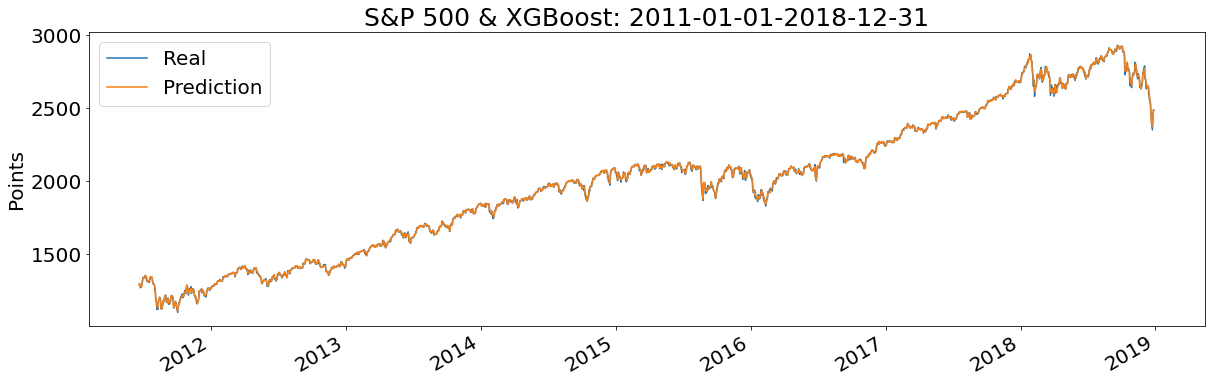

No handles with labels found to put in legend.


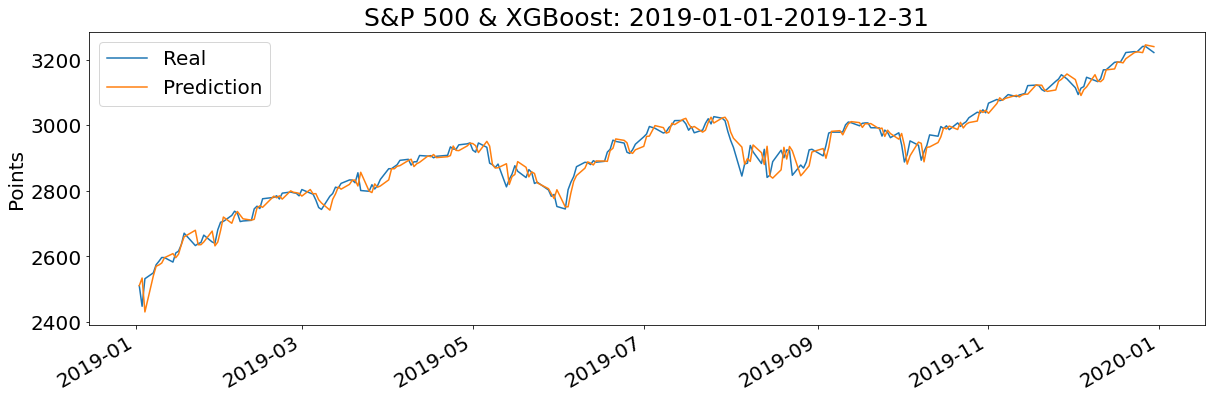

No handles with labels found to put in legend.


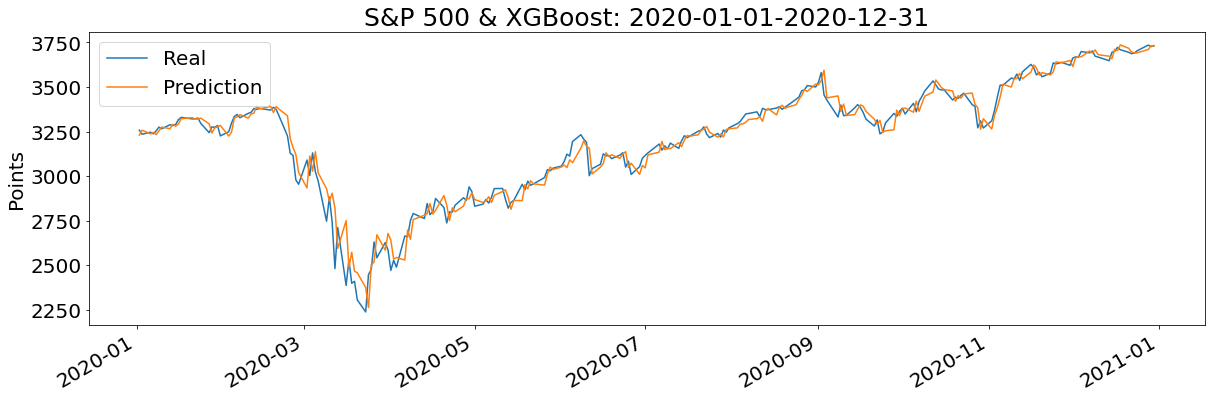

No handles with labels found to put in legend.


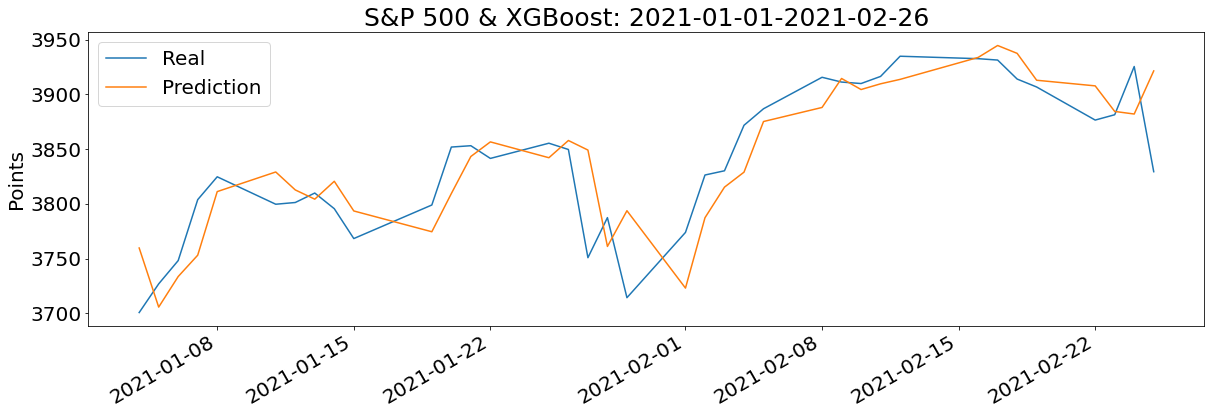

In [24]:
graphCompare("2011-01-01","2018-12-31")
graphCompare("2019-01-01","2019-12-31")
graphCompare("2020-01-01","2020-12-31")
graphCompare("2021-01-01","2021-02-26")

In [22]:
def showBuySell(start_date,end_date):
    df_point_compare = df_return.loc[df_return['Date'].between(start_date,end_date,inclusive=False)]
    
   # df_point_compare = df_point_compare.reset_index()
 #   df_point_compare.head(10)
    fig = plt.figure(figsize=(20,6),dpi=300)
    plt.rcParams['font.size']='20'
    plt.legend(loc =2,prop={'size':20})     
    plt.plot(df_point_compare['Date'],df_point_compare['close'],label='S&P 500')
    fig.autofmt_xdate()
    plt.scatter(df_point_compare.loc[df_point_compare['signal'] =='buy' , 'Date'].values,df_point_compare.loc[df_point_compare['signal'] =='buy', 'close'].values, label='Buy', color='green', s=64, marker="^")
    plt.scatter(df_point_compare.loc[df_point_compare['signal'] =='sell' , 'Date'].values,df_point_compare.loc[df_point_compare['signal'] =='sell', 'close'].values, label='Sell', color='red', s=64, marker="v")
    plt.ylabel('Price',fontsize = 20)
    plt.title('XGBoost buy and sell signal: '+start_date+'-'+end_date,fontsize = 25)
    plt.legend()
    plt.savefig('BuySell-'+start_date+'-'+end_date+'.png')

    #df_point_compare.to_csv('point_compare.csv')
    #plt.set_size_inches(10,5)
    plt.show()
 

No handles with labels found to put in legend.


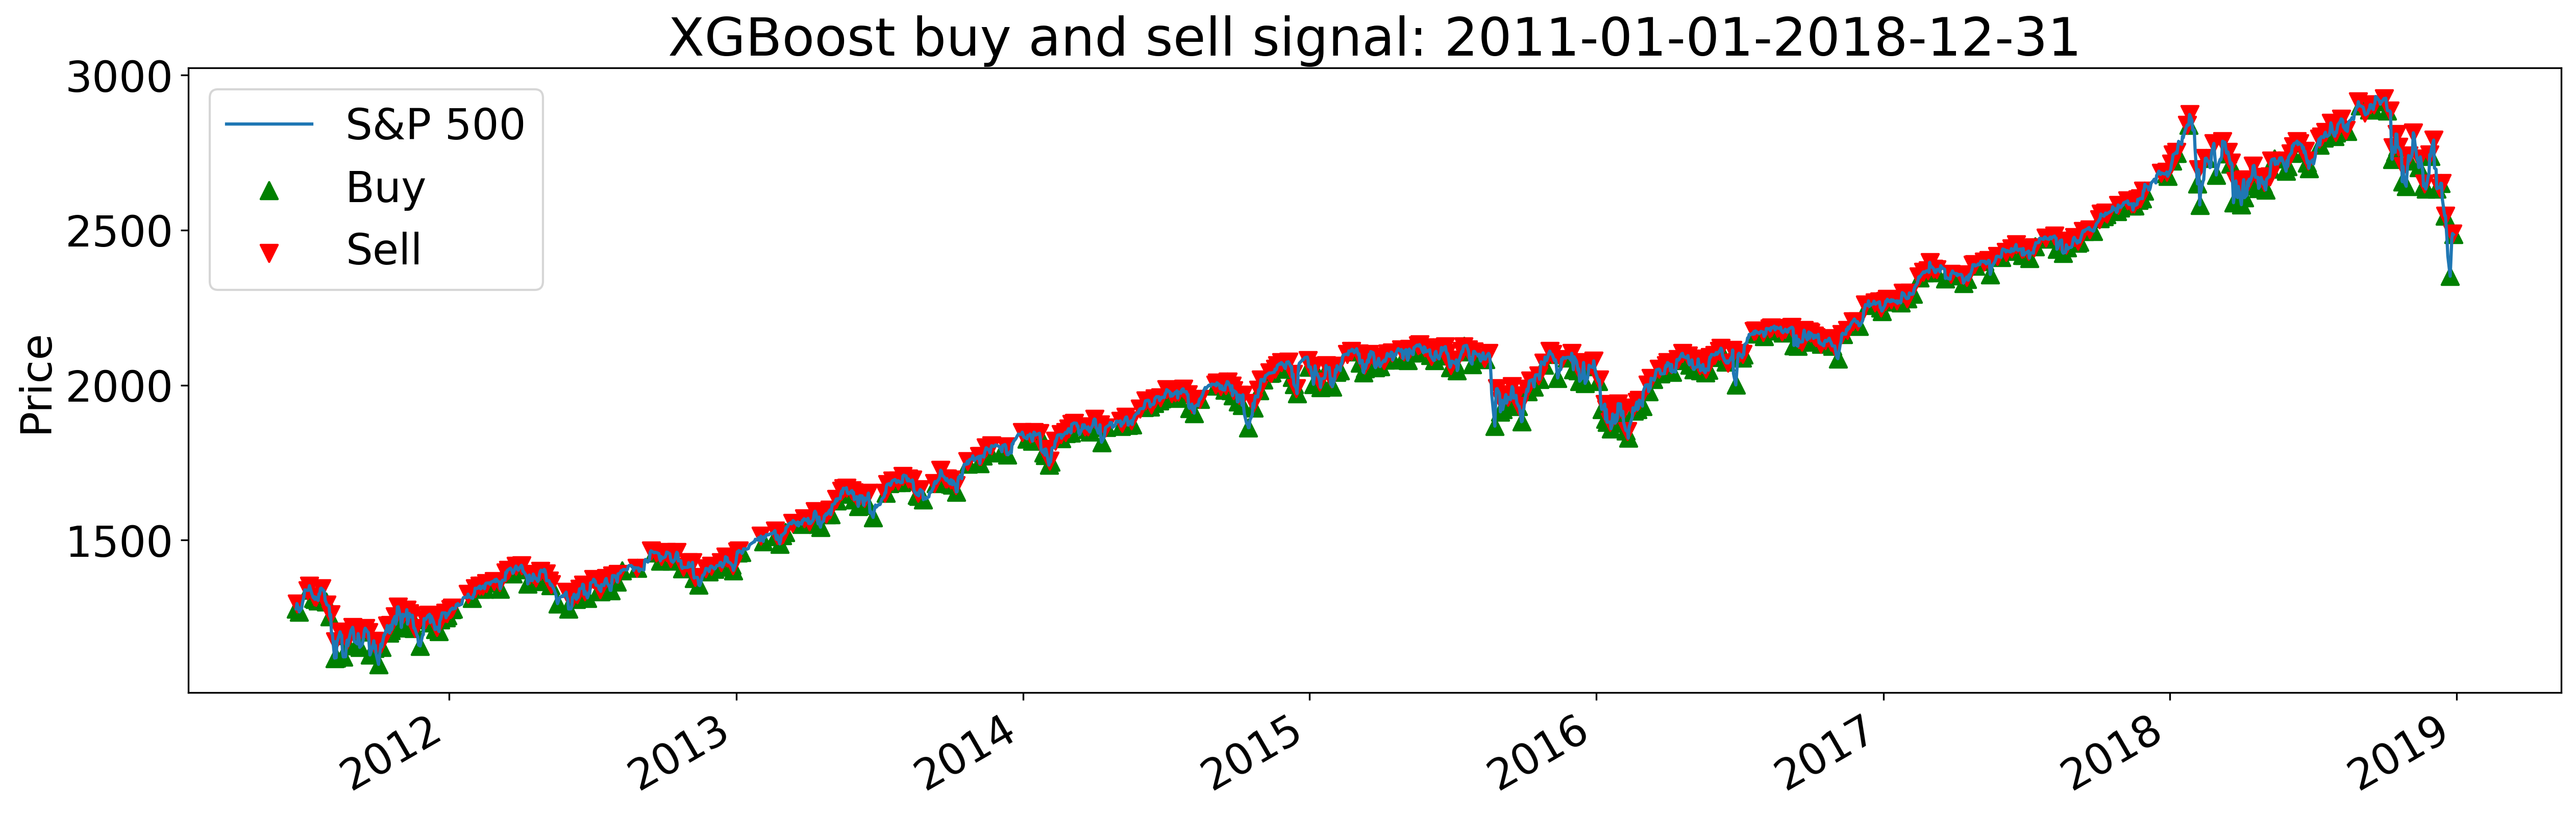

No handles with labels found to put in legend.


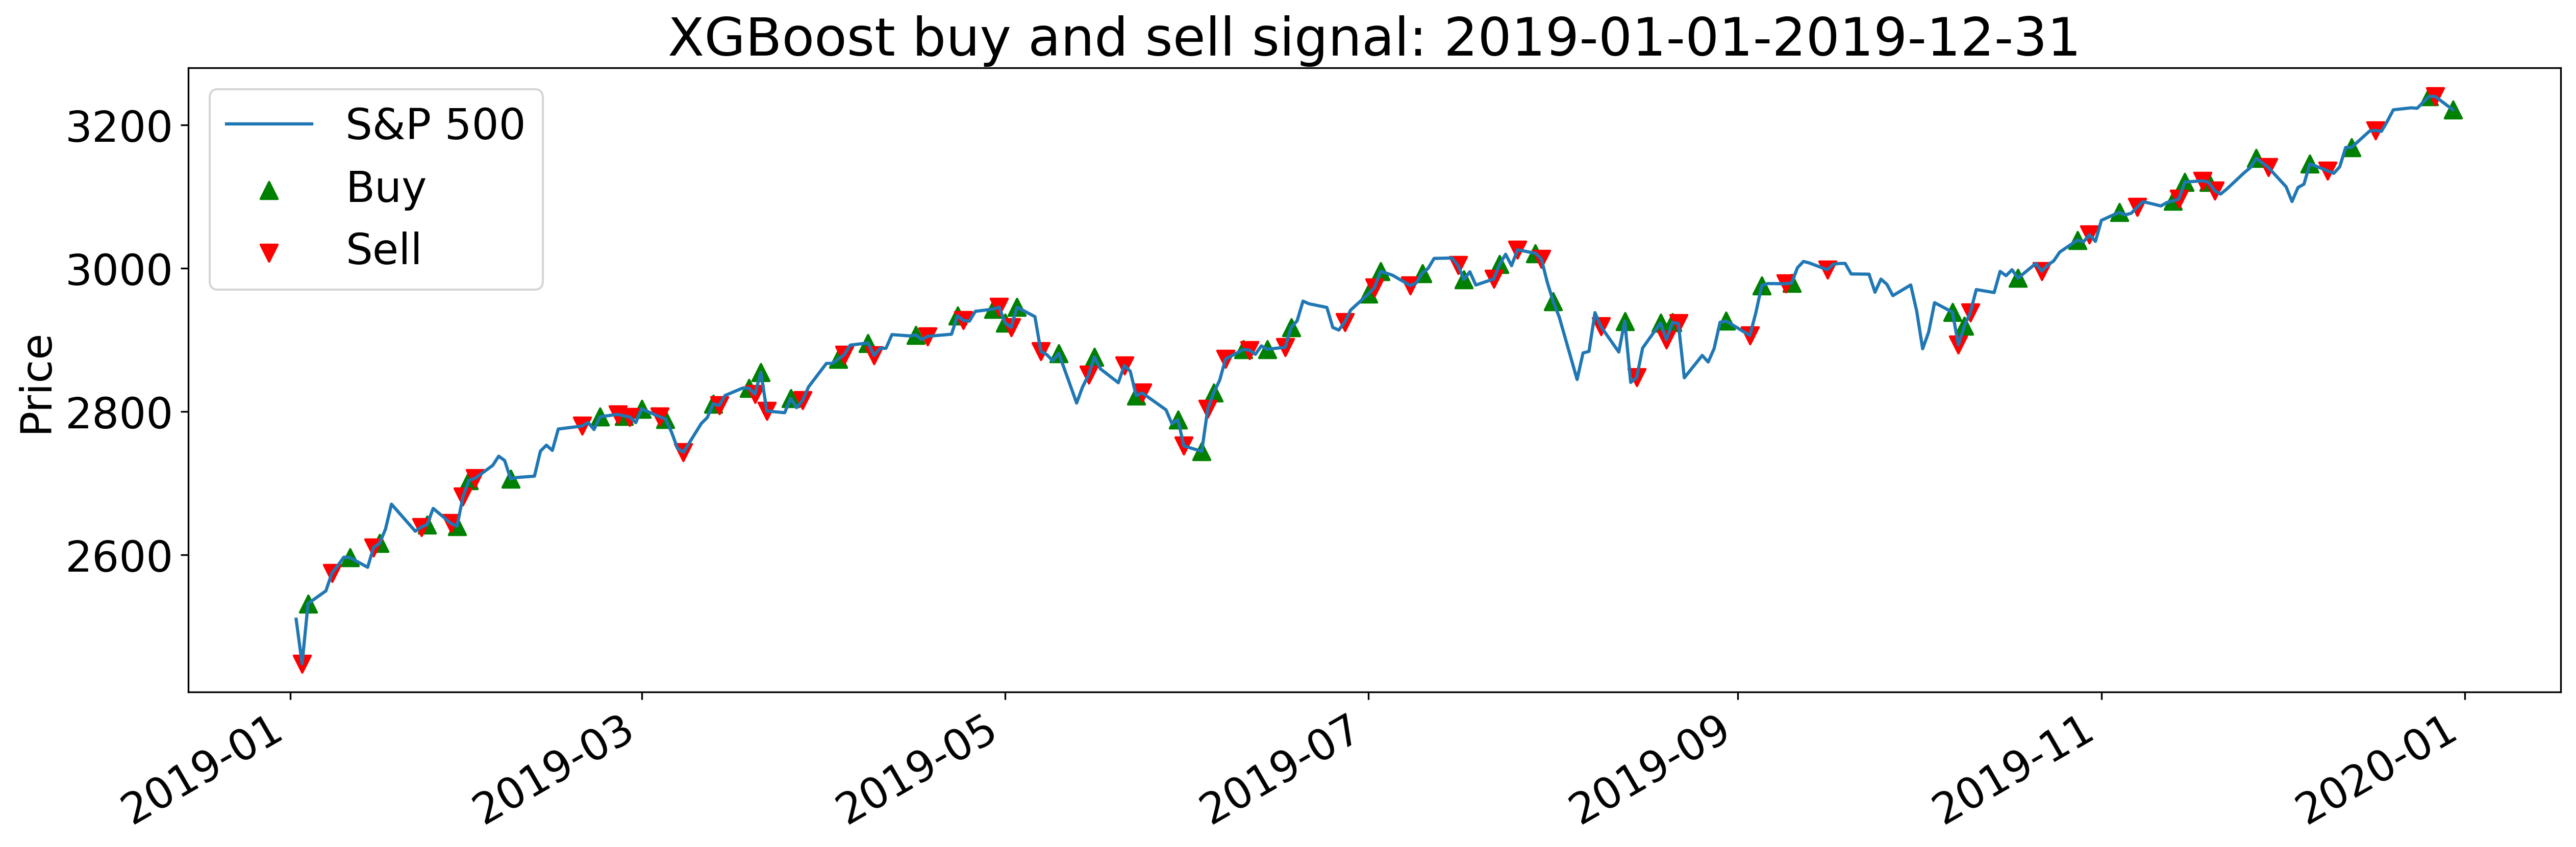

No handles with labels found to put in legend.


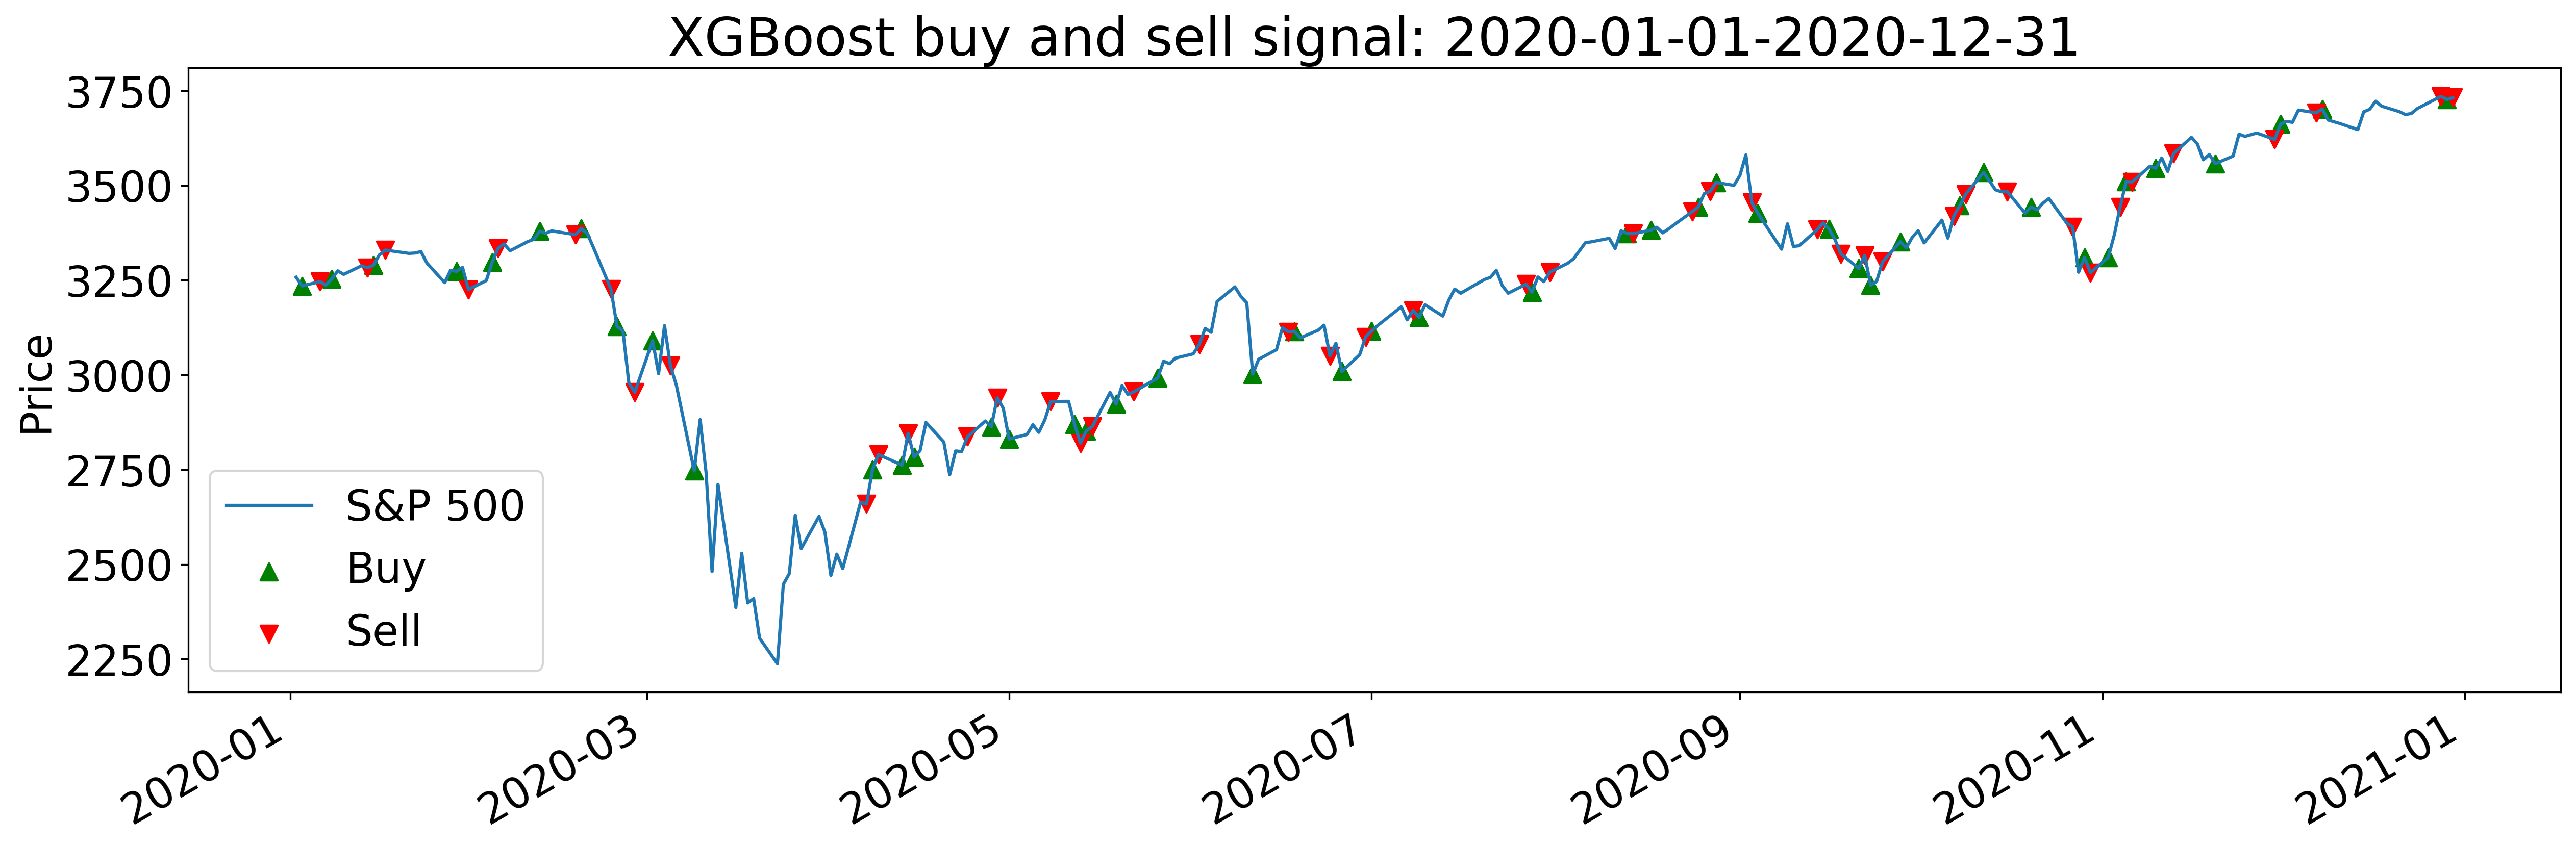

No handles with labels found to put in legend.


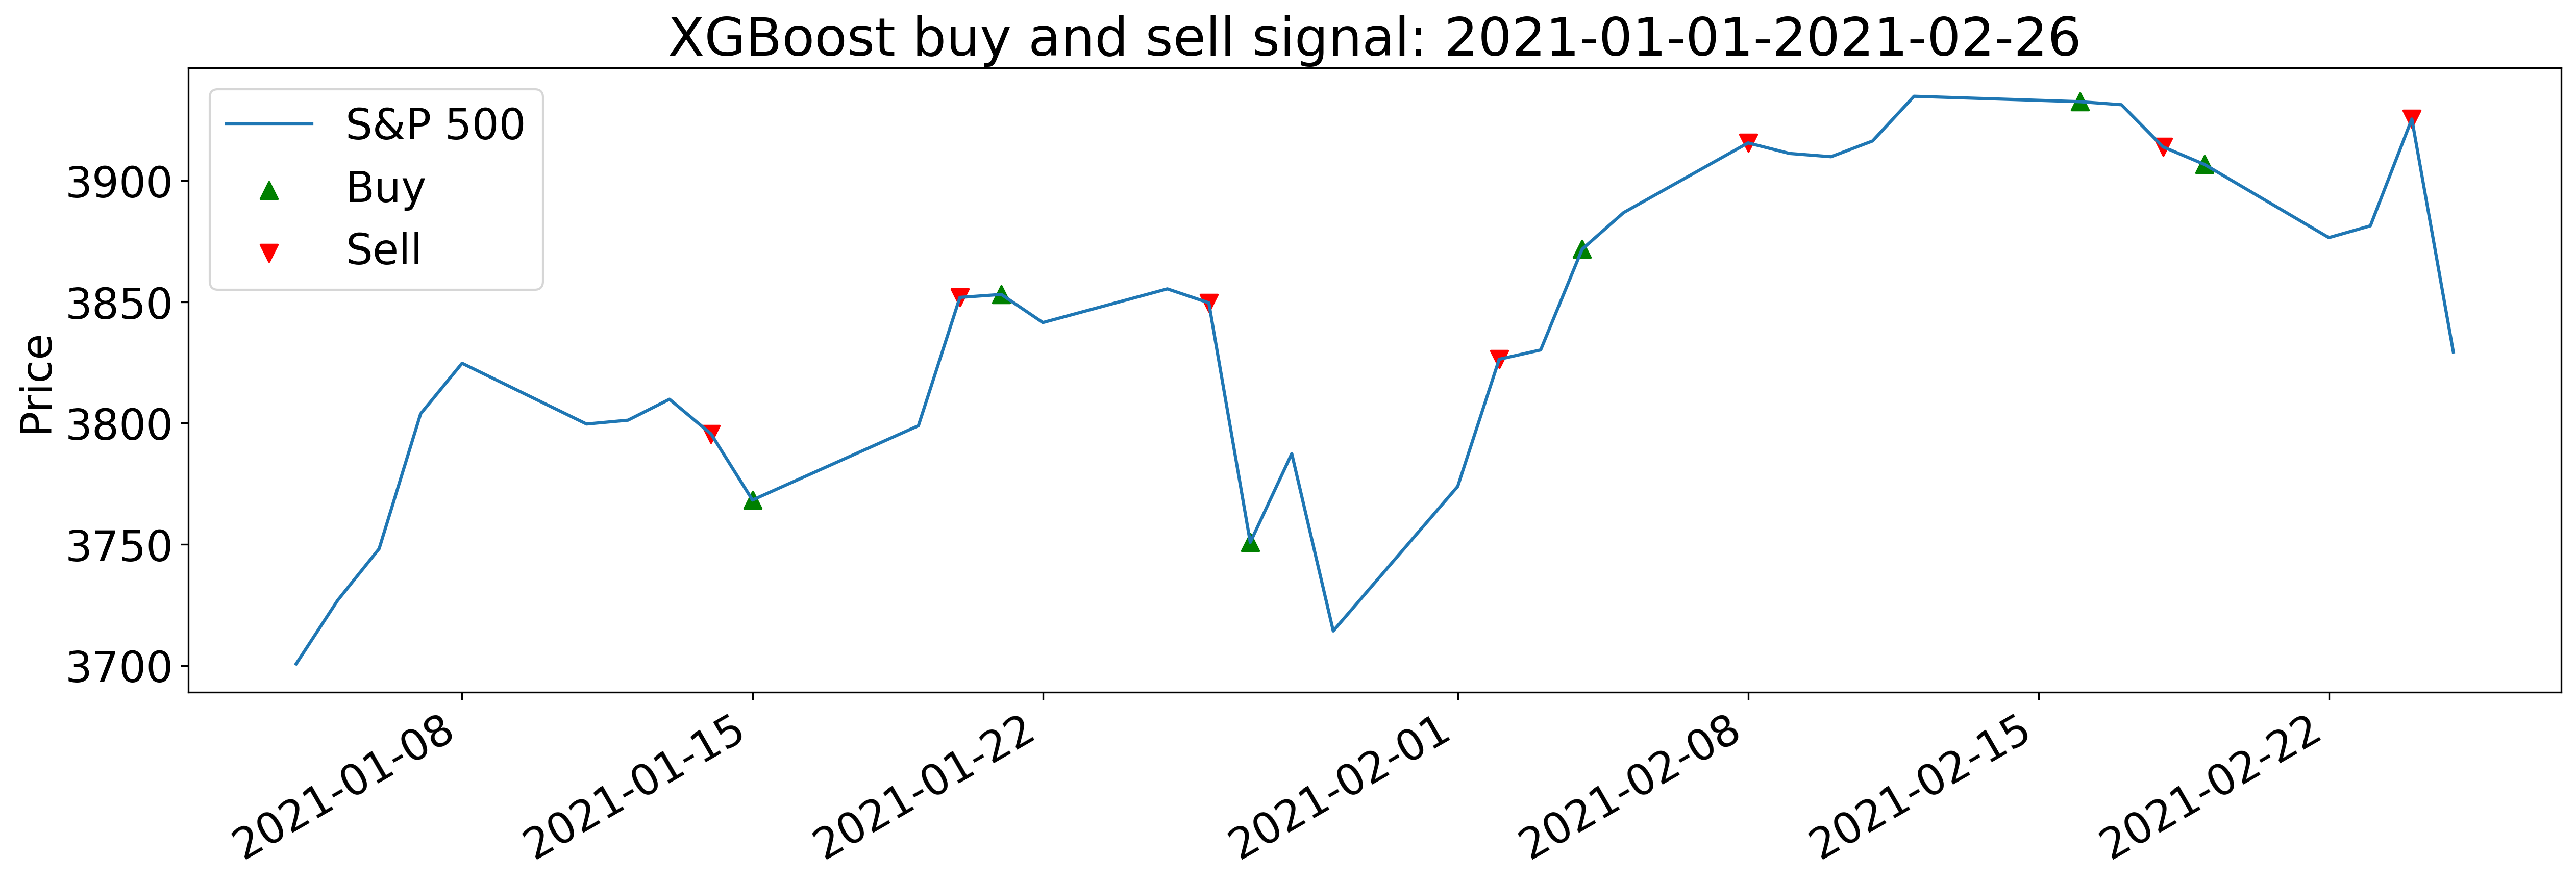

In [23]:
showBuySell("2011-01-01","2018-12-31")
showBuySell("2019-01-01","2019-12-31")
showBuySell("2020-01-01","2020-12-31")
showBuySell("2021-01-01","2021-02-26")